In [ ]:
device='cpu'
import torch
import numpy as np
import random
import matplotlib.pyplot as plt


def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


### BREEDING SIMULATOR
class Genome:
    def __init__(self, n_chr, n_loci, seed=None):
        self.ploidy = 2
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.shape = (self.ploidy, self.n_chr, self.n_loci)
        if seed is not None:
            set_seed(seed)

class Population:
    def __init__(self, genome, haplotypes, device=device):
        self.genome = genome
        self.device = device
        self.phenotypes = None
        self.bvs = None
        self.haplotypes = haplotypes.to(device)
        self.dosages = haplotypes.sum(dim=1).float().to(device)
        self.size = haplotypes.shape[0]

class Trait:
    def __init__(self, genome, founder_population, target_mean, target_variance, device=device, seed=None):
        if seed is not None:
            set_seed(seed)
        self.target_mean = target_mean
        self.target_variance = target_variance
        self.device = device
        random_effects = torch.randn(genome.n_chr, genome.n_loci, device=self.device)

        self.device = device
        random_effects = torch.randn(genome.n_chr, genome.n_loci, device=self.device)
        random_effects -= random_effects.mean()
        founder_scores = torch.einsum('kl,hkl->h', random_effects, founder_population.dosages).to(device)
        founder_mean, founder_var = founder_scores.mean(), founder_scores.var()
        scaling_factors = torch.sqrt(self.target_variance / founder_var)
        self.scaling_factors = scaling_factors
        random_effects *= scaling_factors
        self.effects = random_effects
        self.intercept = founder_mean - target_mean

class SimParams:
    def __init__(self, G, T, h2, reps, pop_size, max_generations, founder_pop, seed=None):
        self.G = G
        self.T = T
        self.h2 = h2
        self.reps = reps
        self.pop_size = pop_size
        self.max_generations = max_generations
        self.founder_pop = founder_pop
        self.seed = seed
        if seed is not None:
            set_seed(seed)

def scale_values(x, from_range=(-1, 1), to_range=(0.05, 0.95)):
    # Ensure input is a PyTorch tensor
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    
    # Unpack the ranges
    from_min, from_max = from_range
    to_min, to_max = to_range
    
    # Scale the values
    scaled = (x - from_min) / (from_max - from_min) * (to_max - to_min) + to_min
    
    return scaled


## ACTIONS

def calculate_breeding_value(population, trait, device=device):
    return torch.einsum('hjk,jk->h', population.dosages, trait.effects).to(device)

def truncation_selection(population, trait, top_percent):
    return torch.topk(population.phenotypes, top_percent).indices.to(device)



def bv(P,T):
    P.breeding_values = calculate_breeding_value(P.dosages,T.effects)

def phenotype(population, trait, h2):
    breeding_values = calculate_breeding_value(population, trait)
    population.breeding_values = breeding_values
    if breeding_values.var() == 0:
        environmental_variance = 0
    else:
        environmental_variance = (1 - h2) / h2 * breeding_values.var()

    # Check if environmental_variance is zero before applying torch.sqrt and .clone()
    if environmental_variance == 0:
        environmental_noise = torch.zeros(breeding_values.shape, device=device)
    else:
        environmental_noise = torch.randn(breeding_values.shape, device=device) * torch.sqrt(environmental_variance).detach()

    population.breeding_values = breeding_values
    population.phenotypes = breeding_values + environmental_noise

def create_pop(G, haplotypes):
    return Population(G, haplotypes=haplotypes)

def create_random_pop(G, pop_size):
    return torch.randint(0, 2, (pop_size, *G.shape), device=device)

def update_pop(population, haplotype_pop_tensor):
    population.haplotypes = haplotype_pop_tensor
    population.dosages = haplotype_pop_tensor.sum(dim=1).float()
    return population

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:], parent_haplo_tensor[:,1,:,:]
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
    progeny = maternal * (1 - crossovers) + paternal * crossovers
    return progeny






# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:],parent_haplo_tensor[:,1,:,:],
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
#     crossovers = torch.rand((num_individuals, num_chromosomes, num_loci), device=device) < recombination_rate
    progeny = maternal * torch.logical_not(crossovers) + paternal * crossovers
    return progeny

def breed(mother_tensor, father_tensor, recombination_rate=0.1):
    eggs = recombine(mother_tensor,recombination_rate)
    pollens = recombine(father_tensor,recombination_rate)
    return torch.stack((eggs,pollens), dim=1)



def create_progeny(mother_gametes, father_gametes, reps=1, device=device):
    # Repeat gametes along a new dimension for replications
    mother_gametes = mother_gametes.unsqueeze(1).repeat(1, reps, 1, 1, 1)
    father_gametes = father_gametes.unsqueeze(1).repeat(1, reps, 1, 1, 1)

    # Shuffle indices for all replications at once
    shuffled_mother_indices = torch.randperm(mother_gametes.shape[0], device=device)
    shuffled_father_indices = torch.randperm(father_gametes.shape[0], device=device)
    shuffled_mother_indices = shuffled_mother_indices.unsqueeze(1).repeat(1, reps)
    shuffled_father_indices = shuffled_father_indices.unsqueeze(1).repeat(1, reps)

    # Gather shuffled gametes and stack
    mother_gametes = torch.gather(mother_gametes, 0, shuffled_mother_indices.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(-1, -1, ploidy, num_chromosomes, num_loci))
    father_gametes = torch.gather(father_gametes, 0, shuffled_father_indices.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(-1, -1, ploidy, num_chromosomes, num_loci))
    progeny_haplotypes = torch.stack((mother_gametes, father_gametes), dim=2)
    return progeny_haplotypes.reshape(-1, 2, num_chromosomes, num_loci)


def random_crosses(parent_population, total_crosses, device=device, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    
    num_parents = parent_population.shape[0]
    ploidy, num_chromosomes, num_loci = parent_population.shape[1:]
    
    # Randomly select parents for each cross
    parent_indices = torch.randint(0, num_parents, (total_crosses, 2), device=device)
    
    # Select the parent haplotypes
    mothers = parent_population[parent_indices[:, 0]]
    fathers = parent_population[parent_indices[:, 1]]
    
    # Perform recombination for both parents
    mother_gametes = recombine(mothers)
    father_gametes = recombine(fathers)
    
    # Combine gametes to create progeny
    progeny = torch.stack((mother_gametes, father_gametes), dim=1)
    
    return progeny

def phenotype(population, trait, h2):
    breeding_values = calculate_breeding_value(population, trait)
    population.breeding_values = breeding_values
    population.genetic_var = breeding_values.var()
    if breeding_values.var() == 0:
        environmental_variance = 0
    else:
        environmental_variance = (1 - h2) / h2 * breeding_values.var()

    # Check if environmental_variance is zero before applying torch.sqrt and .clone()
    if environmental_variance == 0:
        environmental_noise = torch.zeros(breeding_values.shape, device=device)
    else:
        environmental_noise = torch.randn(breeding_values.shape, device=device) * torch.sqrt(environmental_variance).detach()
    population.phenotypes = breeding_values + environmental_noise


In [ ]:

# Example usage
n_chr = 1
n_parents = 20
n_loci = 200
founder_pop_size = 50
h2 = 1
reps = 1
max_generations = 10
seed = 1  # Choose any integer for your seed
G = Genome(n_chr, n_loci, seed=seed)

#set up the initial population

founder_haplotypes = np.load('./data/g2f_ch10.npy') 
random_parent_indicies =  np.random.choice(founder_haplotypes.shape[0], n_parents, replace=False)
random_loci_indices = np.random.choice(founder_haplotypes.shape[2], n_loci, replace=False)
founder_haplotypes = founder_haplotypes[random_parent_indicies,:,:]
founder_haplotypes = founder_haplotypes[:,:,random_loci_indices]
founder_haplotypes = torch.tensor(founder_haplotypes)
founder_haplotypes = founder_haplotypes.unsqueeze(2) 


founder_pop = create_pop(G, founder_haplotypes)
founder_pop = random_crosses(founder_pop.haplotypes,founder_pop_size)
founder_pop = create_pop(G, founder_pop)



T = Trait(G, founder_pop, target_mean=0.0, target_variance=1.0, seed=seed)
SP = SimParams(G, T, h2, reps, founder_pop_size, max_generations, founder_pop, seed=seed)


In [ ]:
phenotype(founder_pop,T,h2)

(array([4., 0., 2., 0., 1., 5., 2., 8., 1., 6., 5., 1., 4., 1., 2., 1., 4.,
        2., 0., 1.]),
 array([-2.14003015, -1.93680394, -1.73357785, -1.53035164, -1.32712543,
        -1.12389922, -0.92067313, -0.71744692, -0.51422077, -0.3109946 ,
        -0.10776842,  0.09545776,  0.29868394,  0.50191009,  0.7051363 ,
         0.90836245,  1.1115886 ,  1.31481481,  1.51804101,  1.7212671 ,
         1.92449331]),
 <BarContainer object of 20 artists>)

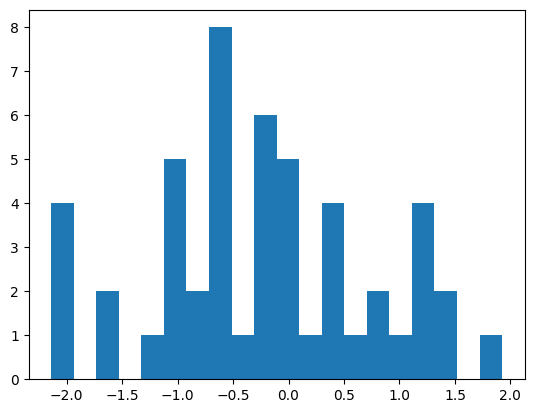

In [ ]:
plt.hist(founder_pop.breeding_values,bins=20)

(array([ 1.,  5.,  7., 16., 43., 48., 48., 18.,  8.,  6.]),
 array([-0.35291427, -0.28902411, -0.22513393, -0.16124377, -0.09735359,
        -0.03346342,  0.03042675,  0.09431692,  0.15820709,  0.22209726,
         0.28598744]),
 <BarContainer object of 10 artists>)

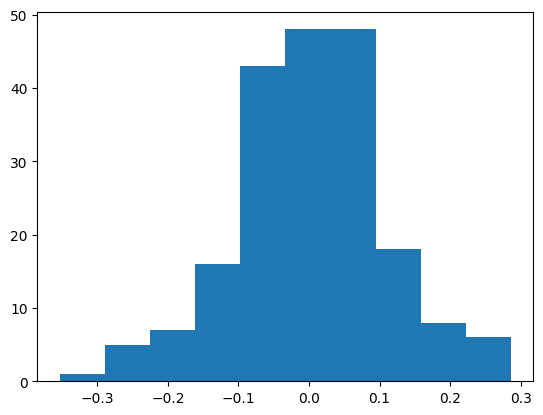

In [ ]:
plt.hist(T.effects.flatten())

In [ ]:
selected = torch.topk(founder_pop.breeding_values, int(SP.pop_size * .3)).indices
f2 = random_crosses(founder_pop.haplotypes[selected], SP.pop_size)
f2 = create_pop(G,f2)
phenotype(f2, T, h2)

(array([2., 3., 1., 2., 1., 1., 3., 1., 3., 3., 3., 2., 3., 0., 3., 6., 4.,
        5., 3., 1.]),
 array([-1.43484211, -1.20443082, -0.97401947, -0.74360818, -0.51319683,
        -0.28278553, -0.05237422,  0.17803709,  0.4084484 ,  0.63885975,
         0.86927104,  1.09968233,  1.33009362,  1.56050503,  1.79091632,
         2.0213275 ,  2.25173903,  2.48215032,  2.71256161,  2.9429729 ,
         3.17338419]),
 <BarContainer object of 20 artists>)

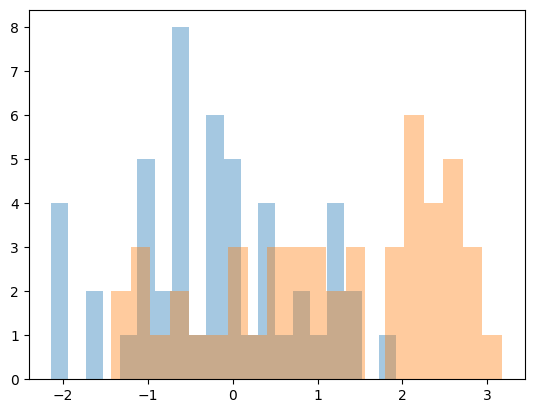

In [ ]:
plt.hist(founder_pop.breeding_values,bins=20,alpha=.4)
plt.hist(f2.breeding_values,bins=20,alpha=.4)